In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

In [2]:
def read_attributes_info():
    """This function reads and adjust the file attributes_info. 
    This file is used to replace the code of missing values for all the columns"""
    # Auxiliar function for casting column values
    def cast_values(value):
        if type(value) == str:
            if value[0] == '[':
                return [int(x) for x in value[1:-1].split(',')]
            else:
                return int(value)
        else:
            return value
        
    attributes_inf = pd.read_csv('data/attributes_info.csv', index_col = 0) 

    # Casting values
    attributes_inf['Missing values code'] = attributes_inf['Missing values code'].apply(cast_values)

    return attributes_inf

In [3]:
# Main cleaning function

def clean_data(dataframe):
    """
    This is the main cleaning function. It receives as input a dataframe such as azdias, customers or MAILOUT's
    and performs all the cleaning steps, mainly those related with missing values (we impute or drop columns or rows)
    """
    ########### Initial Steps ####################################
    # Remove first column ('Unnamed: 0')
    dataframe.drop(dataframe.columns[0], axis = 1, inplace = True)
    
    # Fixing the mixed type warnings
    dataframe.iloc[:,18] = dataframe.iloc[:,18].replace({'X': np.nan})
    dataframe.iloc[:,19] = dataframe.iloc[:,19].replace({'XX': np.nan})
    
    # Casting
    dataframe.iloc[:, 18] = dataframe.iloc[:, 18].map(float)
    dataframe.iloc[:, 19] = dataframe.iloc[:, 18].map(float)
    
    ########### Missing values  ##############################
    missing_1 = dataframe.isnull().sum().sum()
    print('Initial amount of missing values:', missing_1)
    
    print('\nReading the description of attributes table....')
    attributes_info = read_attributes_info()
    
    # Replacing code for missing values using attributes_info
    for att in attributes_info.index:
        code = attributes_info.loc[att, 'Missing values code']
        if type(code) in [int, list]:
            try:   # try because some attributes do not appear in the actual dataframes...
                dataframe[att] = dataframe[att].replace(code, np.nan)
            except:
                continue

    print('\nMissing values after including missing codes', dataframe.isnull().sum().sum())
    print('Additional missing values:', dataframe.isnull().sum().sum() - missing_1)
    
    
    # Dropping attributes and value imputation
    print('\nStarting the cleaning of attributes and feature engineering...')
    
    # The following columns will be dropped due to its high amounts of missing values, or for being irrelevant to the problem
    columns_to_drop = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'TITEL_KZ', 'AGER_TYP', 
                       'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'D19_LETZTER_KAUF_BRANCHE']
    
    dataframe.drop(columns_to_drop, axis = 1, inplace = True)
    
    
    
    # "PLZ8" attributes
    # Most are going to be dropped (the ones related with cars)....
    
    columns_to_drop = list(attributes_info[attributes_info['Information level'] == 'PLZ8'].iloc[:-7].index) + list(attributes_info[attributes_info['Information level'] == 'PLZ8'].iloc[-3:].index)
    # Make sure the columns are in the dataset
    columns_to_drop = list( set(columns_to_drop).intersection(set(dataframe.columns)) )
    
    dataframe.drop(columns_to_drop, axis = 1, inplace = True)
    
    # ... we left ANTG1-4 because they provide information about family houses. We fill NaN's with the most frequent value
    for col in ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4']:
        dataframe[col].fillna(dataframe[col].mode().values[0], inplace = True)
    
    # "Microcell (RR3_ID)" attributes
    # We drop them. Irrelevant to the task
    columns_to_drop = list(attributes_info[attributes_info['Information level'] == 'Microcell (RR3_ID)'].index)
    columns_to_drop = list( set(columns_to_drop).intersection(set(dataframe.columns)) )
    dataframe.drop(columns_to_drop, axis = 1, inplace = True)
    
    # These features also refer to specifications of cars
    cols = ['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4']
    dataframe.drop(cols, axis = 1, inplace = True)
    
    # "Person" attributes
    # The reasoning behind the actions for each attribute can be found in woorkbook_1
    dataframe['ALTERSKATEGORIE_GROB'].fillna(0, inplace = True)  # Filling with 0's
    dataframe.drop(['ALTERSKATEGORIE_FEIN'], axis = 1, inplace = True)
    
    dataframe['CJT_GESAMTTYP'].fillna(dataframe['CJT_GESAMTTYP'].mode().iloc[0], inplace = True) # Filling most common
    dataframe = pd.get_dummies(dataframe, columns = ['CJT_GESAMTTYP'])  # Converting to dummy variables
    
    dataframe['HH_EINKOMMEN_SCORE'].fillna(dataframe['HH_EINKOMMEN_SCORE'].mode().values[0], inplace = True)
    
    # Engineering the 'ALTER' (age) attribute
    dataframe['GEBURTSJAHR'].replace(0, np.nan, inplace = True) # Year of birth
    dataframe['ALTER'] = 2021 - dataframe['GEBURTSJAHR']
    # using another attribute (also related to age) to impute values in ALTER
    dataframe['ALTERSKATEGORIE_GROB'].replace(9, dataframe['ALTERSKATEGORIE_GROB'].mode().iloc[0], inplace = True)
    dataframe['ALTER'].mask( dataframe['ALTER'].isnull(), dataframe['ALTERSKATEGORIE_GROB'] * 17, inplace = True)
    # Dropping GEBURTSJAHR and ALTERSKATEGORIE_GROB they are "inside" ALTER
    dataframe.drop(['GEBURTSJAHR', 'ALTERSKATEGORIE_GROB'], axis = 1, inplace = True)
    
    # more dropping
    dataframe.drop(['GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN'], axis = 1, inplace = True)
    
    dataframe['LP_LEBENSPHASE_GROB'].fillna(dataframe['LP_LEBENSPHASE_GROB'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['LP_LEBENSPHASE_GROB'])
    
    # LP_FAMILIE...
    dataframe.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis = 1, inplace = True)
    dataframe['LP_FAMILIE_GROB'].fillna(dataframe['LP_FAMILIE_GROB'].mode().values[0], inplace = True)
    dataframe['LP_STATUS_GROB'].fillna(dataframe['LP_STATUS_GROB'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB'])
    
    # Nationalitaet
    dataframe['NATIONALITAET_KZ'].fillna(0, inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['NATIONALITAET_KZ'])
    
    dataframe.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    dataframe['RETOURTYP_BK_S'].fillna(dataframe['RETOURTYP_BK_S'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['RETOURTYP_BK_S'])
    
    dataframe['SHOPPER_TYP'].fillna(4, inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['SHOPPER_TYP'])
    
    dataframe['VERS_TYP'].fillna(dataframe['VERS_TYP'].mode().values[0], inplace = True)
    
    dataframe = pd.get_dummies(dataframe, columns = ['ZABEOTYP'])
    
    
    # Attributes related with where people live... This is hard to impute... we assign random values...
    for at in ['MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNDAUER_2008', 'WOHNLAGE']:
        dataframe[at].fillna(method = 'ffill', inplace = True)
        
    # Other irrelevant features:
    dataframe.drop(['ANZ_PERSONEN', 'ANZ_TITEL'], axis = 1, inplace = True)
    
    # Household attributes
    dataframe.drop(['ALTER_HH'], axis = 1, inplace = True)
    dataframe['W_KEIT_KIND_HH'].fillna(dataframe['W_KEIT_KIND_HH'].mode().values[0], inplace = True)
    
    # D19 Transacion data
    dataframe['D19_KONSUMTYP'].fillna(9.0, inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['D19_KONSUMTYP'])
    
    dataframe['D19_BANKEN_ONLINE_QUOTE_12'].fillna(11.0, inplace = True)
    dataframe['D19_GESAMT_ONLINE_QUOTE_12'].fillna(11.0, inplace = True)
    dataframe['D19_VERSAND_ONLINE_QUOTE_12'].fillna(11.0, inplace = True)
    
    # Building attributes
    dataframe.drop(['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HH_TITEL'], axis = 1, inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['GEBAEUDETYP'])
    dataframe['GEBAEUDETYP_5.0'] = pd.Series(0, index = dataframe.index)  #Adding this dummy column manually
    dataframe.drop(['KBA05_HERSTTEMP', 'KBA05_MODTEMP'], axis = 1, inplace = True)
    dataframe['KONSUMNAEHE'].fillna(dataframe['KONSUMNAEHE'].mode().values[0], inplace = True)
    
    dataframe['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace = True)
    
    dataframe['GEBAEUDETYP_RASTER'].fillna(dataframe['GEBAEUDETYP_RASTER'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['GEBAEUDETYP_RASTER'])
    
    # KKK (imputing values)
    # define auxiliar series similar to HH_EINKOMMEN_SCORE, but with some minor changes.
    income_dic = {2.0: 1.0, 3.0: 2.0, 4.0: 3.0, 5.0: 4.0, 6.0: 4.0}
    aux_enikommen = dataframe['HH_EINKOMMEN_SCORE'].replace(income_dic)
    # Use mask for imputing values in KKK
    dataframe['KKK'].mask( dataframe['KKK'].isnull(), aux_enikommen, inplace = True)
    
    # MOBI_regio
    dataframe['MOBI_REGIO'].fillna(method = 'ffill', inplace = True)
    
    dataframe['ONLINE_AFFINITAET'].fillna(dataframe['ONLINE_AFFINITAET'].mode().values[0], inplace = True)
    
    dataframe['REGIOTYP'].fillna(dataframe['REGIOTYP'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['REGIOTYP'])
    
    dataframe['BALLRAUM'].fillna(dataframe['BALLRAUM'].mode().values[0], inplace = True)
    
    dataframe['EWDICHTE'].fillna(dataframe['EWDICHTE'].mode().values[0], inplace = True)
    
    dataframe['INNENSTADT'].fillna(dataframe['INNENSTADT'].mode().values[0], inplace = True)
    
    dataframe['ARBEIT'].replace({9.0: np.nan}, inplace = True)
    dataframe['ARBEIT'].fillna(dataframe['ARBEIT'].mode().values[0], inplace = True)
    
    dataframe['ORTSGR_KLS9'].fillna(dataframe['ORTSGR_KLS9'].mode().values[0], inplace = True)
    
    dataframe['RELAT_AB'].fillna(dataframe['RELAT_AB'].mode().values[0], inplace = True)
    
    # CAMEO_
    dataframe.drop(['CAMEO_DEU_2015', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
    dataframe['CAMEO_DEUG_2015'].fillna(dataframe['CAMEO_DEUG_2015'].mode().values[0], inplace = True)
    dataframe = pd.get_dummies(dataframe, columns = ['CAMEO_DEUG_2015'])
    
    # Attributes without description...
    for at in ['CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 
               'CJT_KATALOGNUTZER', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 
               'D19_VERSI_ONLINE_QUOTE_12', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'RT_KEIN_ANREIZ', 
               'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'UMFELD_ALT', 'UMFELD_JUNG', 'UMFELD_ALT', 'KONSUMZELLE', 'FIRMENDICHTE']:
        dataframe[at].fillna(dataframe[at].mode().values[0], inplace = True)
    
    # Attributes without description to be dropped:
    dataframe.drop(['AKT_DAT_KL', 'ANZ_KINDER', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 
                    'VK_ZG11', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'STRUKTURTYP'], axis = 1, inplace = True)
    
    dataframe.drop(['DSL_FLAG', 'KBA13_ANTG1','KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 
                     'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210',
                   'MOBI_RASTER', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VHA'], axis = 1, inplace = True)
    

    return dataframe

### Reading file

In [4]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv')

training_clean = clean_data(mailout_train)

print('\n\nMissing values:', training_clean.isnull().sum().sum())

print(training_clean.shape)
#training_clean

C:\Users\jobqu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Initial amount of missing values: 2217201

Reading the description of attributes table....

Missing values after including missing codes 2354411
Additional missing values: 137210

Starting the cleaning of attributes and feature engineering...


Missing values: 0
(42962, 214)


In [5]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv')

test_clean = clean_data(mailout_test)

print('\n\nMissing values:', test_clean.isnull().sum().sum()) 

print(test_clean.shape)
#test_clean

Initial amount of missing values: 2186771

Reading the description of attributes table....

Missing values after including missing codes 2322980
Additional missing values: 136209

Starting the cleaning of attributes and feature engineering...


Missing values: 0
(42833, 213)


### StandarScaler

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

training_clean.set_index(['LNR'], inplace = True)

train_scaled = scaler.fit_transform(training_clean.drop(['RESPONSE'], axis = 1))

train_scaled = pd.DataFrame(train_scaled, columns = list(training_clean.columns)[:-1], index = training_clean.index)

train_scaled.head()

,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,...,REGIOTYP_6.0,REGIOTYP_7.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,-0.220282,0.203551,0.756779,-0.396140,-0.211671,0.563449,0.580345,0.560862,0.580973,-0.224018,...,-0.286551,-0.242063,-0.350607,-0.338773,-0.368279,3.996789,-0.66823,-0.277121,-0.36333,-0.24645
1771,-1.216569,0.203551,-1.329511,-0.396140,-0.211671,-0.521138,-1.309792,0.560862,-0.443101,1.978334,...,-0.286551,-0.242063,-0.350607,-0.338773,-0.368279,3.996789,-0.66823,-0.277121,-0.36333,-0.24645
1776,0.776006,-1.704266,0.756779,-1.138807,-0.929186,0.563449,0.580345,0.560862,0.580973,-0.224018,...,-0.286551,-0.242063,2.852196,-0.338773,-0.368279,-0.250201,-0.66823,-0.277121,-0.36333,-0.24645
1460,0.776006,-1.227312,0.756779,-0.396140,-0.211671,0.563449,0.580345,0.560862,-0.443101,-0.224018,...,-0.286551,-0.242063,2.852196,-0.338773,-0.368279,-0.250201,-0.66823,-0.277121,-0.36333,-0.24645
1783,-0.220282,-0.273403,0.756779,-1.138807,-0.211671,0.563449,0.580345,0.560862,0.580973,-0.224018,...,3.489775,-0.242063,-0.350607,-0.338773,-0.368279,-0.250201,-0.66823,3.608537,-0.36333,-0.24645


### PCA

In [7]:
# From sklearn
from sklearn.decomposition import PCA

In [8]:
def display_component(v, features_list, component_num, n_weights=10):
    global n_components
    
    # get index of component (last row - component_num)
    row_idx = len(v) - component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

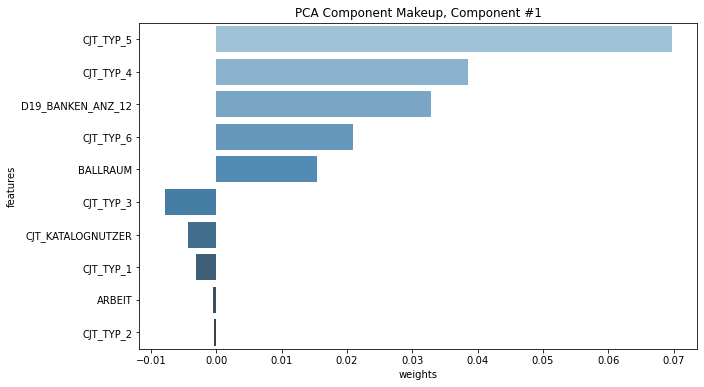

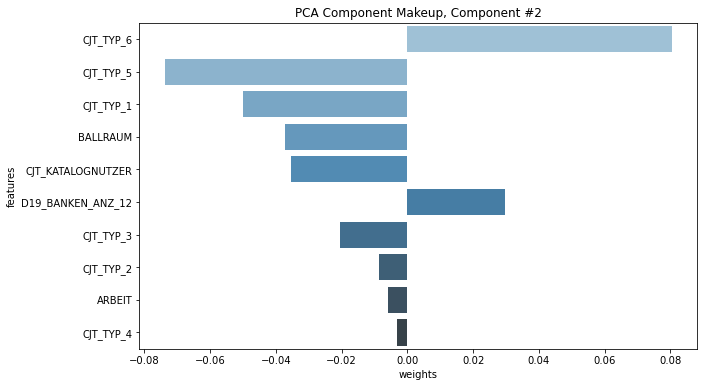

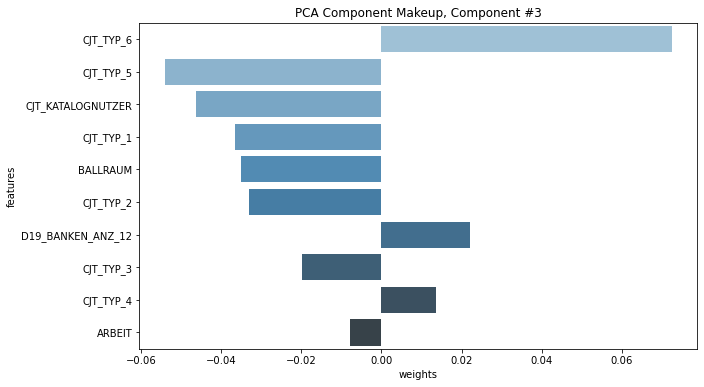

In [9]:
pca = PCA(10) 

# Transform features
training_pca = pca.fit_transform(training_clean)

# display makeup of the first three components
display_component(pd.DataFrame( pca.components_ ), training_clean.columns.values, component_num = 1, n_weights = 10)
display_component(pd.DataFrame( pca.components_ ), training_clean.columns.values, component_num = 2, n_weights=10)
display_component(pd.DataFrame( pca.components_ ), training_clean.columns.values, component_num = 3, n_weights=10)